# Apply a spectral sea level equation solver to  Antarctic drainage basin outlines
*Author: R. Rietbroek Nov 2024 (r.rietbroek@utwente.nl)*

When a surface load, e.g. a changing glacier load, is applied on the crust of the Earth it induces changes in gravity and a deformation of teh Earth. A passive but self-consistent ocean responds by adapting to the new geoid but also enforces a mass conservation (e.g. the mass from the melting glacier should be added to the ocean). This are generally considered Self Attraction and Loading (SAL) effects. The theory goes back to Woodward 1888 ("On the form and position of mean sea level"). A spectral approach, specialized for ocean pole tide is provided in Dahlen 1976 ("The passive influence of the oceans upon the rotation of the Earth").

For a given surface load, the computation of a SAL response of the ocean can be done by solving the sea level equation. This notebook demonstrates the use of the specral sea level solves as provided by shxarray.

## 1. Preparations

In [1]:
#Optionally enable autoreloading for development purposes. Note that this does not automagically reload the binary extensions
%load_ext autoreload
%autoreload 2

In [2]:
from shxarray.earth.sealevel import SpectralSeaLevelSolver
import xarray as xr
import os
import requests
from shxarray.kernels.axial import ParabolicCap
from shxarray.geom.polygons import polygon2sh
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#set the maximum degree of the sea level equation solver
nmax=120

## 2. Get a set of Antartic grounded drainage basins to use as continental loads

Text(0.5, 1.0, 'Antarctic grounded drainage basins')

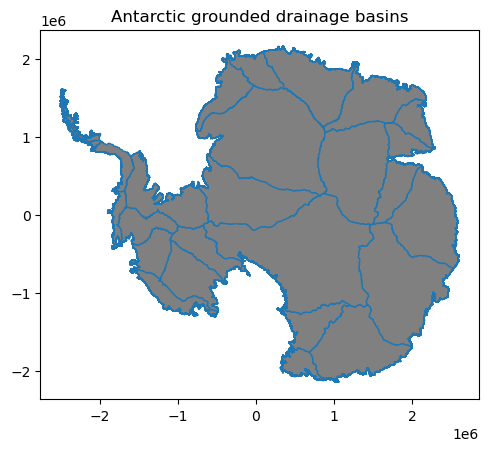

In [7]:
# In this example we're loading the drainage basin outlines froma geoslurp database
# The original datasources can be found at https://earth.gsfc.nasa.gov/cryo/data/polar-altimetry/antarctic-and-greenland-drainage-systems
from geoslurp.manager import GeoslurpManager
import geoslurp.tools.pandas  
import pandas as pd
gsman=GeoslurpManager(dbalias="tunnelmarge")
tname="cryo.antarc_ddiv_icesat_grnd"

# One can populate the database like this:
#dsant=gsman.dataset(tname")
#dsant.pull()
#dsant.register()

#load the polygons from the databse in a geopandas dataframe NOTE: convert to polar stereographic projection because the polgyon contains the south Pole
#And this projection is needed when converting to spherical harmonics
dfant=pd.DataFrame.gslrp.load(gsman.conn,f"SELECT basinid,ST_transform(geom::geometry,3031) as geom FROM {tname}")
# quick plot of the drainage basin outlines
ax=dfant.plot(edgecolor="tab:blue",facecolor="grey")
ax.set_title("Antarctic grounded drainage basins")

## 3 Convert the drainage outline to spherical harmonics of the desired degrees

In [8]:
dantsh=polygon2sh(dfant.geometry,nmax,auxcoord=dfant.basinid)
display(dantsh)

shxarray-INFO: Gridding polygons
shxarray-INFO: Applying SH analysis


<xarray.DataArray (basinid: 26, nm: 14641)> Size: 3MB
array([[ 9.35249879e-004, -2.98417988e-004, -1.58836940e-003, ...,
        -6.73740082e-071, -8.24373566e-072,  1.57643357e-073],
       [ 1.51642372e-003, -4.08984702e-005, -2.61911845e-003, ...,
         2.38210395e-101, -1.68832323e-103,  4.94768085e-107],
       [ 3.04177662e-003,  1.42272790e-004, -5.18789693e-003, ...,
        -4.39038248e-072,  1.05337136e-073, -1.66245556e-075],
       ...,
       [ 1.98102086e-004, -9.48620912e-005, -3.27591542e-004, ...,
         6.99449283e-058, -2.03177167e-060, -4.84564443e-061],
       [ 5.69892029e-005, -3.49694318e-005, -9.06381789e-005, ...,
        -1.58534500e-046, -7.16860463e-046,  2.58137837e-047],
       [ 7.57868335e-005, -4.60878341e-005, -1.20652495e-004, ...,
        -5.30623439e-046, -3.91274031e-050,  7.26843713e-049]])
Coordinates:
  * basinid  (basinid) float64 208B 2.0 3.0 4.0 5.0 6.0 ... 24.0 25.0 26.0 27.0
  * nm       (nm) object 117kB MultiIndex
  * n        (nm) int64 117kB 0 1 1 1 2 2 2 2 ... 120 120 120 120 120 120 120
  * m        (nm) int64 117kB 0 -1 0 1 -2 -1 0 1 ... 114 115 116 117 118 119 120

## 4 Check if the intermediate drainage basin results made sense
A spatially discontinuous function cannnot be one-to-one mapped to spectrally truncated function, so some Gibb's phenomena is to be expected


Text(0.5, 1.0, 'Antarctic drainage basin 18 from sh nmax=120')

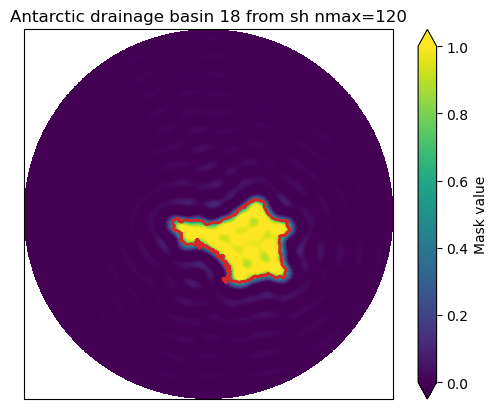

In [45]:
# Sum all spherical harmonic coefficient sets for all basins and grid
import cartopy.crs as ccrs
dres=0.25
basinid=18
# basinid=3
daantgrd=dantsh.sel(basinid=basinid).sh.synthesis(lon=np.arange(-180+dres/2,180,dres),lat=np.arange(-90+dres/2,-60,dres))
daantgrd.name="Mask value"
# daantgrd=daantgrd[daantgrd.lat < -50]
ax = plt.axes(projection=ccrs.SouthPolarStereo())
daantgrd.plot(ax=ax,vmax=1,vmin=0,transform=ccrs.PlateCarree())
ax.add_geometries(dfant[dfant.basinid==basinid].geometry,edgecolor='tab:red',crs=ccrs.SouthPolarStereo(),facecolor="none",lw=2)
plt.title(f"Antarctic drainage basin {basinid} from sh nmax={nmax}")

## 5 Set up the sea level solver
This class precomputes and caches a product2sum matrix of the ocean function which can take a while for higher degrees. It is also possible to add a custom ocean function expressed in spherical harmonic coefficients. The default uses the ocean sh coefficients from [this notebook](https://github.com/ITC-Water-Resources/shxarray/blob/main/docs/source/notebooks/OceanMask.ipynb)

In [53]:
rotfeedback=False #possibly set to True to also apply rotational feedback
sle=SpectralSeaLevelSolver(nmax=nmax,rotfeedback=rotfeedback)

shxarray-INFO: /home/roelof/.cache/shxarray_storage/ocean/ne_10m_oceansh_n300.nc, already downloaded
shxarray-INFO: /home/roelof/.cache/shxarray_storage/Love/geoslurp_dump_llove.sql already exists, no need to download)
shxarray-INFO: /home/roelof/.cache/shxarray_storage/Love/geoslurp_dump_llove.sql already exists, no need to download)
shxarray-INFO: Reading product2sum ocean function from cache: /home/roelof/.cache/shxarray_storage/P2S/p2s_ocean_n120.nc


In [127]:
dsant_sle=sle(dantsh)
display(dsant_sle)


shxarray-INFO: current mass inconsistency: iteration 0, relratio:0.08208356020957885
shxarray-INFO: current mass inconsistency: iteration 1, relratio:0.006783887944904573
shxarray-INFO: current mass inconsistency: iteration 2, relratio:0.0019016928532825485
shxarray-INFO: current mass inconsistency: iteration 3, relratio:0.00042550227956553307
shxarray-INFO: current mass inconsistency: iteration 4, relratio:9.69538415069509e-06


<xarray.Dataset> Size: 16MB
Dimensions:     (nm: 14641, basinid: 26)
Coordinates:
  * nm          (nm) object 117kB MultiIndex
  * n           (nm) int64 117kB 0 1 1 1 2 2 2 2 ... 120 120 120 120 120 120 120
  * m           (nm) int64 117kB 0 -1 0 1 -2 -1 0 ... 115 116 117 118 119 120
  * basinid     (basinid) float64 208B 2.0 3.0 4.0 5.0 ... 24.0 25.0 26.0 27.0
Data variables:
    quasi_sea   (nm, basinid) float64 3MB -0.00124 -0.001959 ... 6.317e-11
    load_sea    (nm, basinid) float64 3MB -0.0009353 -0.001516 ... 6.909e-09
    load_force  (basinid, nm) float64 3MB 0.0009352 -0.0002984 ... 7.268e-49
    geoid       (nm, basinid) float64 3MB 0.0 0.0 0.0 ... 1.241e-11 1.538e-11
    uplift      (nm, basinid) float64 3MB 0.0 0.0 0.0 ... -3.858e-11 -4.779e-11
Attributes:
    history:  2024-12-06 23:34:34.469605: shxarray (SpectralSeaLevelSolver

In [124]:
def plot_sle(dsslice):
    # dsgrid=dsslice.sh.synthesis(lon=np.arange(-180+dres/2,180,dres),lat=np.arange(-90+dres/2,-60,dres))
    dsgrid=dsslice.sh.synthesis()
    dsgrid.load_force.attrs["units"]="m"
    dsgrid.load_sea.attrs["units"]="m"
    dsgrid.quasi_sea.attrs["units"]="m"
    dsgrid.geoid.attrs["units"]="m"
    dsgrid.uplift.attrs["units"]="m"
    cmap="RdBu_r"
    cbaropts=dict(location="bottom")
    
    proj=ccrs.NearsidePerspective(central_longitude=0.0, central_latitude=-50, satellite_height=35785831) 
    fig, axs = plt.subplots(nrows=2,ncols=3, subplot_kw={'projection': proj},figsize=(12,8.5))
    ax=axs[0,0]
    dsgrid.load_force.plot.contourf(ax=ax,cmap=cmap,transform=ccrs.PlateCarree(),cbar_kwargs=cbaropts)
    ax.coastlines()
    ax.set_title("Drainage basin load")


    ax=axs[0,1]
    slmin=1.1*dsgrid.load_sea.min().item()
    slmax=1.1*dsgrid.load_sea.max().item()
    dsgrid.load_sea.plot.contourf(ax=ax,cmap=cmap,transform=ccrs.PlateCarree(),vmin=slmin,vmax=slmax,cbar_kwargs=cbaropts)
    ax.coastlines()
    ax.set_title("Relative sea level")

    ax=axs[0,2]
    dsgrid.quasi_sea.plot.contourf(ax=ax,cmap=cmap,transform=ccrs.PlateCarree(),vmin=slmin,vmax=slmax,cbar_kwargs=cbaropts)
    ax.coastlines()
    ax.set_title("Quasi Sea level")

    ax=axs[1,0]
    dsgrid.geoid.plot.contourf(ax=ax,cmap=cmap,transform=ccrs.PlateCarree(),cbar_kwargs=cbaropts)
    ax.coastlines()
    ax.set_title("Geoid change")

    ax=axs[1,1]
    dsgrid.uplift.plot.contourf(ax=ax,cmap=cmap,transform=ccrs.PlateCarree(),cbar_kwargs=cbaropts)
    ax.coastlines()
    ax.set_title("Uplift change")
    # plt.subplots_adjust(bottom=0.1, right=0.2, top=0.9)
    fig.delaxes(axs[1,2])
   


## 6 plot the sealevel equation components of all the drainage basin loads combined (a uniform Antarctic load)

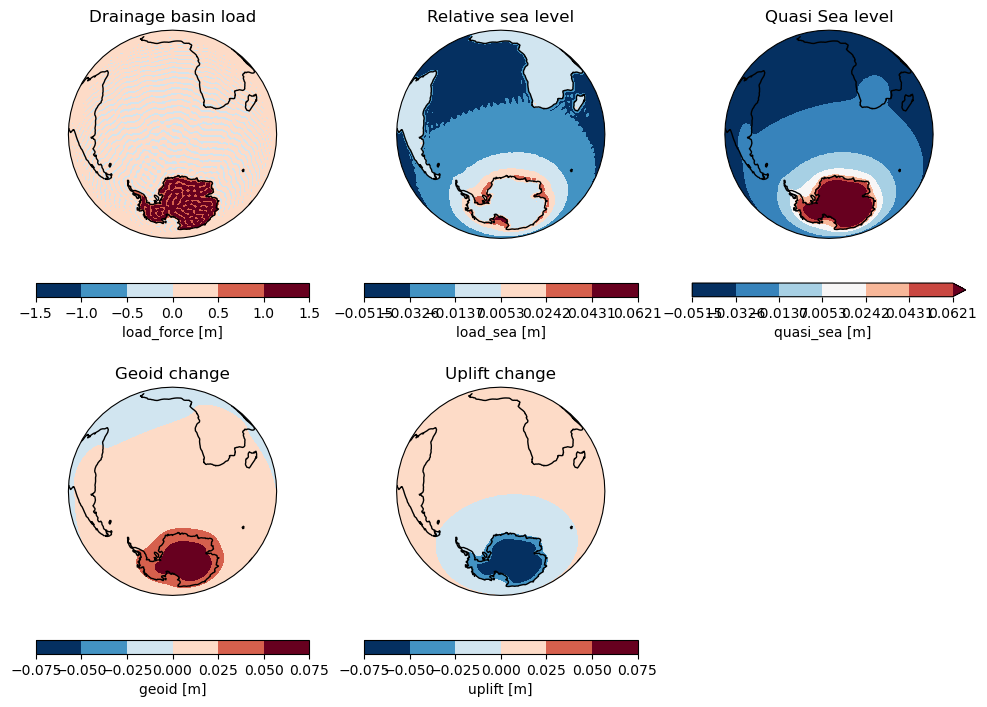

In [125]:
# plot the effects of all loads together
plot_sle(dsant_sle.sum("basinid"))


## 7 Plot the contribution for a specific basin
* Note that the truncation degree relative to the size of the load is smaller, which can be seen in ringing effects.
* Also note that the quasi Sea level is much smoother than the relative sea level close to the coastlines, but it's value over land is invalid.

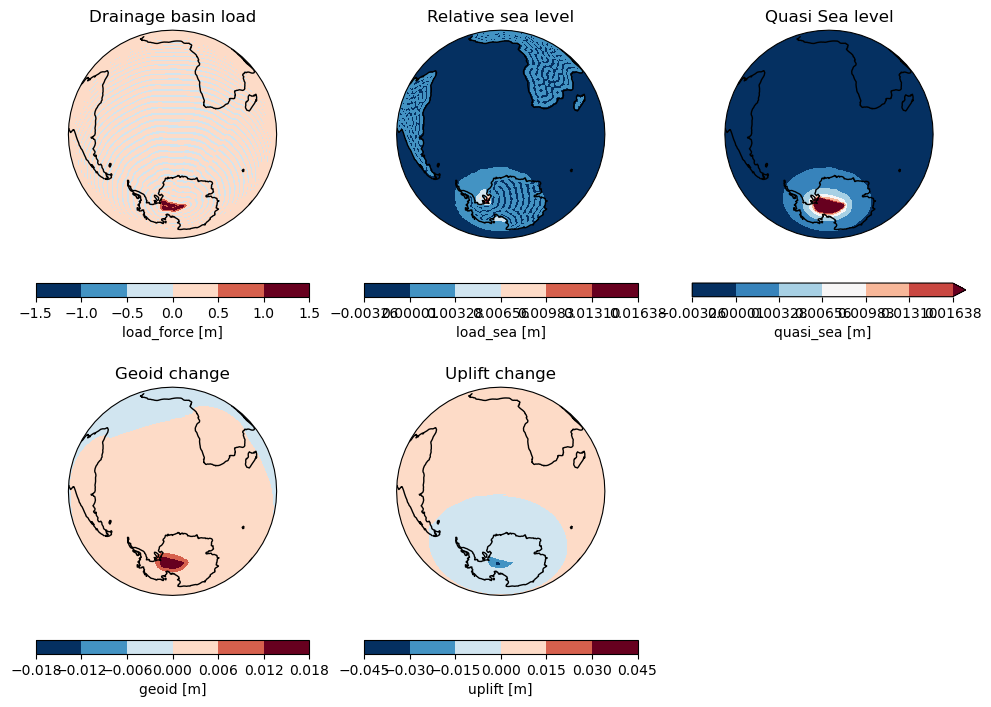

In [126]:
# plot the effect of a specific drainage basin
plot_sle(dsant_sle.sel(basinid=3))